# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In this project, I am pretty interesed to target the customers who has successfully affected by the offer based on their profile. I am also interested to find out which offer channels and offer type works best.
So my research question for this project is the following 3:

* #### Which channel works best for sending offers?
* #### Which type offer is the most effective (i.e customer make most transcations after view the offer)
* #### How well are different machine leaning methods in classifing targeted customers?

For the first 2 questions, I will use visualization and numbers(tables) to find out. For the last question, I will use 4 different classification models to find out. **Exciting coding trips begin!!!**

This notebook contain 4 sections:
* #### Explore and prepare data
> 1. Explore data
> 2. Clean data
> 3. Visualize data
* #### Model data
> 1. Preprocessing data for models
> 2. Classification using logic regression
> 3. Classification using LDA
> 4. Classification using QDA
> 5. Classification using KNN
* #### Results discussion
* #### Conclusion and futher improvement

* References: ISLP
* 

In [254]:
# import libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #linear discriminant analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis #quadratic discriminant analysis
from sklearn.neighbors import KNeighborsClassifier #K nearest neighbours (KNN)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample


In [23]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore and prepare data
In this section, I will take a look at the data, and preprocessing it to make it clean. In the modeling section, I will further create metrics from the cleaned data for my ML models.

### 1.Explore data

In [42]:
# define a function to have a brief check on the data
def check_data(df):
    '''
    function:check if the df has duplicates, nulls, and print the shape, 
    the infomation and the description of the dataframe
    =
    input-df: the dataframe to be checked
    output: None
    '''
    # check nulls
    print('check if df has nulls:')
    print(df.isnull().sum())
    print('\n')

    # check duplicates
    print('check if df has duplicates:')
    try:
        print('dataset has {} duplicate rows'.format(df.duplicated().sum()))
    except TypeError:
        print('not able to check duplicates due to datatype, please check and clean the data and try again')
    print('\n')

    # check the shape
    print('check df shape:')
    print('dataset has {} rows and {} columns'.format(df.shape[0],df.shape[1]))
    print('\n')
    
    # data type info
    print('dataset brief information:')
    print(df.info())
    print('\n')

    # numerical data brief summary
    print('summary for numerical data in this dataset:')
    print(df.describe())
    print('\n')
 

#### 1.1 portfolio data

In [5]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [43]:
check_data(portfolio)

check if df has nulls:
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


check if df has duplicates:
not able to check duplicates due to datatype, please check and clean the data and try again


check df shape:
dataset has 10 rows and 6 columns


dataset brief information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes
None


summary for numerical data in this dataset:
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915  

#### 1.2 profile data

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [44]:
check_data(profile)

check if df has nulls:
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


check if df has duplicates:
dataset has 0 duplicate rows


check df shape:
dataset has 17000 rows and 5 columns


dataset brief information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


summary for numerical data in this dataset:
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07 

#### 1.3 transcript data

In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [45]:
check_data(transcript)

check if df has nulls:
person    0
event     0
value     0
time      0
dtype: int64


check if df has duplicates:
not able to check duplicates due to datatype, please check and clean the data and try again


check df shape:
dataset has 306534 rows and 4 columns


dataset brief information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


summary for numerical data in this dataset:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000




### 2. Clean data

#### 1.1 clean portfolio data
There is no nulls in portfolio data,and I need to clean the data to see if there are any duplicates. therefore, I will create 4 columns - 'email','web','mobile','social',to replace the 'channels' columns.

In [70]:
# clean channels
#get the copy of portfolio data
df_pf = portfolio.copy()

In [71]:
# create encoding for 'channels' column
df_pf['email'] = df_pf['channels'].apply(lambda x: 1 if 'email' in x else 0)
df_pf['web'] = df_pf['channels'].apply(lambda x: 1 if 'web' in x else 0)
df_pf['mobile'] = df_pf['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
df_pf['social'] = df_pf['channels'].apply(lambda x: 1 if 'social' in x else 0)

# drop column 'channels'
df_pf = df_pf.drop(columns ='channels', axis=1)
df_pf

,reward,difficulty,duration,offer_type,id,email,web,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,0,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [52]:
# recheck the cleaned portfolio data
check_data(df_pf)

check if df has nulls:
reward        0
difficulty    0
duration      0
offer_type    0
id            0
email         0
web           0
mobile        0
social        0
dtype: int64


check if df has duplicates:
dataset has 0 duplicate rows


check df shape:
dataset has 10 rows and 9 columns


dataset brief information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   offer_type  10 non-null     object
 4   id          10 non-null     object
 5   email       10 non-null     int64 
 6   web         10 non-null     int64 
 7   mobile      10 non-null     int64 
 8   social      10 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 852.0+ bytes
None


summary for numerical data in this dataset:
          reward  difficulty   du

#### 1.2 clean profile data
In the profile data, I need to deal with nulls, and also double check all non-numerical columns value to see if there are any weired values in those columns. I will also create a column 'member_year' to replace the column 'became_member_on'.

In [54]:
#get the copy of portfolio data
df_pl = profile.copy()
df_pl.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**Deal with null**: As it will be unreasonable to impute null values for genders and it is noticed that the age associate with the null values is 118 (which is also unreasonable), so drop the null values is more appropraciate than impute null values for this dataset

In [55]:
df_pl = df_pl.dropna()
df_pl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [56]:
# check value in gender columns
df_pl['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

In [58]:
# check id in gender columns
df_pl['id'].nunique()

14825

In [65]:
# convert the 'became_member_on' to a datetime project
df_pl['became_member_on'] = pd.to_datetime(df_pl['became_member_on'])

In [68]:
# create the 'member_year' column
df_pl['member_year'] = df_pl['became_member_on'].dt.year

#drop the 'became_member_on' column
df_pl = df_pl.drop(columns = 'became_member_on')
df_pl.head()

,gender,age,id,income,member_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


In [73]:
# recheck the cleaned profile data
check_data(df_pl)

check if df has nulls:
gender         0
age            0
id             0
income         0
member_year    0
dtype: int64


check if df has duplicates:
dataset has 0 duplicate rows


check df shape:
dataset has 14825 rows and 5 columns


dataset brief information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       14825 non-null  object 
 1   age          14825 non-null  int64  
 2   id           14825 non-null  object 
 3   income       14825 non-null  float64
 4   member_year  14825 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB
None


summary for numerical data in this dataset:
                age         income   member_year
count  14825.000000   14825.000000  14825.000000
mean      54.393524   65404.991568   2016.620169
std       17.383705   21598.299410      1.198245
min       18.000000   3

#### 1.3 clean transcript data
In the transcript data, I need the create 3 columns 'offer_id', 'reward', 'amount' column to replace the 'value' column. I will also double check the (number of) unique values in each non-numerical column

In [117]:
#get the copy of portfolio data
df_transcript = transcript.copy()
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [118]:
df_transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [119]:
#Extract offer_id from value column
df_transcript['offer_id'] = df_transcript['value'].apply(lambda x: x['offer id'] if 'offer id' in x else None)
#Extract amount from value column
df_transcript['amount'] = df_transcript['value'].apply(lambda x: x['amount'] if 'amount' in x else None)
#Extract reward from value column
df_transcript['reward'] = df_transcript['value'].apply(lambda x: x['reward'] if 'reward' in x else None)

# drop value column
df_transcript = df_transcript.drop(columns ='value')
df_transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [120]:
# check unique values in event
df_transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [121]:
# check unique values in time
df_transcript['time'].unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [122]:
# check unique values in offer_id
df_transcript['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', None], dtype=object)

In [123]:
# check unique values in reward
df_transcript['reward'].unique()

array([nan,  2.,  5., 10.,  3.])

In [124]:
# recheck cleaned transcript data
check_data(df_transcript)

check if df has nulls:
person           0
event            0
time             0
offer_id    172532
amount      167581
reward      272955
dtype: int64


check if df has duplicates:
dataset has 924 duplicate rows


check df shape:
dataset has 306534 rows and 6 columns


dataset brief information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   offer_id  134002 non-null  object 
 4   amount    138953 non-null  float64
 5   reward    33579 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB
None


summary for numerical data in this dataset:
                time         amount        reward
count  306534.000000  138953.000000  33579.000000
mean      366.382940      12.777356      4.904137
std       

**Drop duplicates**: from above recheck, we can see there are many duplicates in the cleaned data, and I need to drop them. 

In [125]:
df_transcript = df_transcript.drop_duplicates()
check_data(df_transcript)

check if df has nulls:
person           0
event            0
time             0
offer_id    171608
amount      166657
reward      272955
dtype: int64


check if df has duplicates:
dataset has 0 duplicate rows


check df shape:
dataset has 305610 rows and 6 columns


dataset brief information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 305610 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    305610 non-null  object 
 1   event     305610 non-null  object 
 2   time      305610 non-null  int64  
 3   offer_id  134002 non-null  object 
 4   amount    138953 non-null  float64
 5   reward    32655 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.3+ MB
None


summary for numerical data in this dataset:
                time         amount        reward
count  305610.000000  138953.000000  32655.000000
mean      365.954216      12.777356      4.903169
std       20

In [126]:
# it is still a little confusing for me to proceed further for the data cleaning
# I need to take a look at a record of a particular customer
df_transcript[df_transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,None,19.89,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,None,NaN,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,None,17.78,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,None,19.67,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,None,29.72,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,None,23.93,NaN


**Add a offer name to help identify complete offers**:
From a brief view of one person's record, It is hard to tell which offer is completed since there is no offer id associated with the offer completed event. So I will add a offer_name column to df_pf(portfolio) and merge the data to try to find of there is some ways to identify the compelted offers

In [128]:
df_pf['offer_name'] = (df_pf['offer_type'] + "_Reward_" + df_pf['reward'].astype('str')
                          + "_Diff_" + df_pf['difficulty'].astype('str') + "_Dur_"
                          + portfolio['duration'].astype('str'))
df_pf.head()

,reward,difficulty,duration,offer_type,id,email,web,mobile,social,offer_name
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,bogo_Reward_10_Diff_10_Dur_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_Reward_10_Diff_10_Dur_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational_Reward_0_Diff_0_Dur_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo_Reward_5_Diff_5_Dur_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_Reward_5_Diff_20_Dur_10


#### 1.4 merge dataset for visulization and future use

#### Defination metrics for further analysis
**Define offer response rate:**

* **successful offers**:
  >1. **for informational offer**, if the offer is viewed and there is a transaction happend after its view time and within its effective time(although transaction may due to a following offer, but I can not exclude the possiblility that the transaction is made because of both the information and the reward) (construct a transaction table with time, customer_id/ construct a min_time, max_time for the information offer, and create a suceess column to mark 1 if sucess)
  >2. **for all other offers**, if the offer is viewed, a transaction followed it after the view time and within the offer effective time range and there is a offer_completed with the correct reward amount and within its effective time, then it is count as a success offer.



* **offer receive total**:
  I will count total number of the offer_received as the receive_ct

* **offer success total**:
  I will count total number of the sucessful offers as the success_ct
  
* **offer response rate**:
  offer_response_rate = total number of sucessful offers/ total number of offer received

**Define customer type:**
>1. **high sensative consumer**: 'offer response rate' is above average
>2. **low sensative consumer**: 'offer response rate' is below average

In [129]:
# combine transcript and portfolio data on offer_id
df_cob = pd.merge(df_transcript, df_pf, left_on='offer_id', right_on = 'id', how='left')
df_cob.head()

,person,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,id,email,web,mobile,social,offer_name
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,1.0,0.0,discount_Reward_2_Diff_10_Dur_7
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,discount_Reward_2_Diff_10_Dur_10
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,bogo_Reward_10_Diff_10_Dur_5


#### Create a dataframe with 'offer received' as the base dataframe 
**Note**: The 3 columns -('person','receive_time','offer_name') form a unique key for the table

In [132]:
# create a dataframe for offer_received as base dataframe for merge
df_offer_rev = df_cob[df_cob['event']=='offer received']

# drop duplicate and unnecessary columns
column_to_drop = ['offer_id','amount','reward_x','id']
df_offer_rev = df_offer_rev.drop(columns = column_to_drop)

#create a column to record the end time of an offer
df_offer_rev['end_time'] = (df_offer_rev['time'] + df_offer_rev['duration']*24)

# rename columns for easy understanding
df_offer_rev = df_offer_rev.rename(columns={'time': 'receive_time','reward_y': 'reward','event': 'receive'})
df_offer_rev.head()

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,social,offer_name,end_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7,168.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,240.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_Reward_2_Diff_10_Dur_7,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,discount_Reward_2_Diff_10_Dur_10,240.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_Reward_10_Diff_10_Dur_5,120.0


#### create 'offer_reveived_view' table by adding 'offer view' information to 'offer_reveived' dataframe

In [133]:
# create a offer_view table
df_offer_view = df_cob[df_cob['event']=='offer viewed']

# extract necessary information and rename column names
df_offer_view = df_offer_view[['person','event','time','offer_name']]
df_offer_view = df_offer_view.rename(columns={'event': 'view','time': 'view_time'})

# left join view table with rev table
df_view_cob = pd.merge(df_offer_rev,df_offer_view, on=['person','offer_name'], how = 'left')

# filter the combined table with condition 
# condition1 :(view time >= reveive_time and view time =< end_time)
df_view_cob = df_view_cob[(df_view_cob['view_time'] >= df_view_cob['receive_time']) & (df_view_cob['view_time'] <= df_view_cob['end_time'])]

# extract necessary information for view table
df_view_cob = df_view_cob[['person','receive_time','offer_name','view','view_time']]

# join two tables with unique key ['person','receive_time','offer_name']
df_rev_view = pd.merge(df_offer_rev,df_view_cob, on=['person','receive_time','offer_name'], how = 'left')
df_rev_view.head()

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,social,offer_name,end_time,view,view_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,6.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_Reward_2_Diff_10_Dur_7,168.0,offer viewed,18.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,discount_Reward_2_Diff_10_Dur_10,240.0,offer viewed,12.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_Reward_10_Diff_10_Dur_5,120.0,offer viewed,84.0


In [134]:
# double check if the result is correct
df_rev_view1 = df_rev_view[df_rev_view['person']=='78afa995795e4d85b5d9ceeca43f5fef']
df_rev_view2 = df_rev_view[df_rev_view['person']=='a03223e636434f42ac4c3df47e8bac43']
df_rev_view12 = pd.concat([df_rev_view1,df_rev_view2])
df_rev_view12

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,social,offer_name,end_time,view,view_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0
12797,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,0.0,0.0,3.0,informational,1.0,0.0,1.0,1.0,informational_Reward_0_Diff_0_Dur_3,240.0,offer viewed,216.0
38995,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,10.0,10.0,7.0,bogo,1.0,0.0,1.0,1.0,bogo_Reward_10_Diff_10_Dur_7,576.0,offer viewed,408.0
52360,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_Reward_5_Diff_5_Dur_5,624.0,offer viewed,582.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,6.0
25648,a03223e636434f42ac4c3df47e8bac43,offer received,336,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,informational_Reward_0_Diff_0_Dur_4,432.0,offer viewed,336.0
38996,a03223e636434f42ac4c3df47e8bac43,offer received,408,0.0,0.0,3.0,informational,1.0,0.0,1.0,1.0,informational_Reward_0_Diff_0_Dur_3,480.0,NaN,NaN
52361,a03223e636434f42ac4c3df47e8bac43,offer received,504,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,744.0,offer viewed,624.0
65552,a03223e636434f42ac4c3df47e8bac43,offer received,576,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,816.0,offer viewed,624.0


#### Create 'offer_reveived_view_transaction' table by adding 'transaction' information to 'offer_reveived_view' dataframe

In [135]:
# create a transaction table
df_trans = df_cob[df_cob['event']=='transaction']

# extract necessary information and rename column names
df_trans = df_trans[['person','event','time','amount']]
df_trans = df_trans.rename(columns={'time':'transaction_time', 'event':'transaction'})

# left join view table with rev_view table
df_trans_cob = pd.merge(df_rev_view,df_trans, on=['person'], how = 'left')

# filter the combined table with condition 
# condition1 : (transaction time >= reveive_time and transaction time =< end_time)
# condition2 : (transaction time >= view time)
# condition3 : (transaction amount >= difficulty)
df_trans_cob = df_trans_cob[(df_trans_cob['transaction_time'] >= df_trans_cob['receive_time']) & (df_trans_cob['transaction_time'] <= df_trans_cob['end_time'])]
df_trans_cob = df_trans_cob[(df_trans_cob['amount'] >= df_trans_cob['difficulty'])]
df_trans_cob = df_trans_cob[(df_trans_cob['transaction_time'] >= df_trans_cob['view_time'])]

# only reserve 1 transaction for 1 offer (if there is a transaction)
df_trans_cob1 =df_trans_cob.drop(columns=['transaction_time','amount'])
set_for_dropdup = df_trans_cob1.columns
df_trans_cob = df_trans_cob.drop_duplicates(subset=set_for_dropdup)
df_trans_cob.head()

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,social,offer_name,end_time,view,view_time,transaction,transaction_time,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89
16,389bc3fa690240e798340f5a15918d5c,offer received,0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_Reward_5_Diff_5_Dur_5,120.0,offer viewed,0.0,transaction,60.0,9.54
70,c27e0d6ab72c455a8bb66d980963de60,offer received,0,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,informational_Reward_0_Diff_0_Dur_4,96.0,offer viewed,18.0,transaction,18.0,13.25
78,d53717f5400c4e84affdaeda9dd926b3,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,30.0,transaction,30.0,339.69
86,f806632c011441378d4646567f357a21,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,discount_Reward_2_Diff_10_Dur_10,240.0,offer viewed,18.0,transaction,126.0,28.29


In [136]:
# double check if the result is correct
df_trans_cob1 = df_trans_cob[df_trans_cob['person']=='78afa995795e4d85b5d9ceeca43f5fef']
df_trans_cob2 = df_trans_cob[df_trans_cob['person']=='a03223e636434f42ac4c3df47e8bac43']
df_trans_cob12 = pd.concat([df_trans_cob1,df_trans_cob2])
df_trans_cob12

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,social,offer_name,end_time,view,view_time,transaction,transaction_time,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89
108325,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,0.0,0.0,3.0,informational,1.0,0.0,1.0,1.0,informational_Reward_0_Diff_0_Dur_3,240.0,offer viewed,216.0,transaction,222.0,19.67
330027,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,10.0,10.0,7.0,bogo,1.0,0.0,1.0,1.0,bogo_Reward_10_Diff_10_Dur_7,576.0,offer viewed,408.0,transaction,510.0,21.72


In [137]:
# extract necessary information for transaction table
df_trans_cob = df_trans_cob[['person','receive_time','offer_name','transaction','transaction_time','amount']]

# join two tables with unique key ['person','receive_time','offer_name']
df_rev_view_trans = pd.merge(df_rev_view,df_trans_cob, on=['person','receive_time','offer_name'], how = 'left')
df_rev_view_trans.head()

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,social,offer_name,end_time,view,view_time,transaction,transaction_time,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,6.0,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_Reward_2_Diff_10_Dur_7,168.0,offer viewed,18.0,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,discount_Reward_2_Diff_10_Dur_10,240.0,offer viewed,12.0,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_Reward_10_Diff_10_Dur_5,120.0,offer viewed,84.0,NaN,NaN,NaN


In [138]:
# double check if the result is correct
df_rev_view_trans1 = df_rev_view_trans[df_rev_view_trans['person']=='78afa995795e4d85b5d9ceeca43f5fef']
df_rev_view_trans2 = df_rev_view_trans[df_rev_view_trans['person']=='a03223e636434f42ac4c3df47e8bac43']
df_rev_view_trans12 = pd.concat([df_rev_view_trans1,df_rev_view_trans2])
df_rev_view_trans12

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,social,offer_name,end_time,view,view_time,transaction,transaction_time,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89
12859,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,0.0,0.0,3.0,informational,1.0,0.0,1.0,1.0,informational_Reward_0_Diff_0_Dur_3,240.0,offer viewed,216.0,transaction,222.0,19.67
39604,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,10.0,10.0,7.0,bogo,1.0,0.0,1.0,1.0,bogo_Reward_10_Diff_10_Dur_7,576.0,offer viewed,408.0,transaction,510.0,21.72
53320,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_Reward_5_Diff_5_Dur_5,624.0,offer viewed,582.0,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,6.0,NaN,NaN,NaN
25784,a03223e636434f42ac4c3df47e8bac43,offer received,336,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,informational_Reward_0_Diff_0_Dur_4,432.0,offer viewed,336.0,NaN,NaN,NaN
39605,a03223e636434f42ac4c3df47e8bac43,offer received,408,0.0,0.0,3.0,informational,1.0,0.0,1.0,1.0,informational_Reward_0_Diff_0_Dur_3,480.0,NaN,NaN,NaN,NaN,NaN
53321,a03223e636434f42ac4c3df47e8bac43,offer received,504,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,744.0,offer viewed,624.0,NaN,NaN,NaN
66844,a03223e636434f42ac4c3df47e8bac43,offer received,576,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_Reward_5_Diff_20_Dur_10,816.0,offer viewed,624.0,NaN,NaN,NaN


#### Create 'offer_reveived_view_transaction_complete' table by adding 'offer complete' information to 'offer_reveived_view_transaction' dataframe

In [139]:
# create a offer_complete table
df_comp = df_cob[df_cob['event']=='offer completed']

# extract necessary information and rename column names
df_comp = df_comp[['person','event','time','reward_x']]
df_comp = df_comp.rename(columns={'time':'complete_time', 'event':'complete','reward_x':'complete_reward'})

# left join view table with rev_view_trans table
df_comp_cob = pd.merge(df_rev_view_trans,df_comp, on=['person'], how = 'left')

# filter the combined table with condition 
# condition1 : (complete time >= reveive_time and complete time =< end_time)
# condition2 : (complete time >= transaction time)
# condition3 : (complete reward == (associated) offer reward)
df_comp_cob = df_comp_cob[(df_comp_cob['complete_time'] >= df_comp_cob['receive_time']) & (df_comp_cob['complete_time'] <= df_comp_cob['end_time'])]
df_comp_cob = df_comp_cob[(df_comp_cob['complete_reward'] == df_comp_cob['reward'])]
df_comp_cob = df_comp_cob[(df_comp_cob['complete_time'] >= df_comp_cob['transaction_time'])]

df_comp_cob.head()


,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,...,offer_name,end_time,view,view_time,transaction,transaction_time,amount,complete,complete_time,complete_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,...,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89,offer completed,132.0,5.0
8,389bc3fa690240e798340f5a15918d5c,offer received,0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,...,bogo_Reward_5_Diff_5_Dur_5,120.0,offer viewed,0.0,transaction,60.0,9.54,offer completed,60.0,5.0
28,d53717f5400c4e84affdaeda9dd926b3,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,30.0,transaction,30.0,339.69,offer completed,30.0,5.0
30,f806632c011441378d4646567f357a21,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,...,discount_Reward_2_Diff_10_Dur_10,240.0,offer viewed,18.0,transaction,126.0,28.29,offer completed,126.0,2.0
33,d058f73bf8674a26a95227db098147b1,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,30.0,transaction,192.0,27.23,offer completed,192.0,5.0


In [140]:
# double check if the result is correct
df_comp_cob1 = df_comp_cob[df_comp_cob['person']=='78afa995795e4d85b5d9ceeca43f5fef']
df_comp_cob2 = df_comp_cob[df_comp_cob['person']=='a03223e636434f42ac4c3df47e8bac43']
df_comp_cob12 = pd.concat([df_comp_cob1,df_comp_cob2])
df_comp_cob12

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,...,offer_name,end_time,view,view_time,transaction,transaction_time,amount,complete,complete_time,complete_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,...,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89,offer completed,132.0,5.0
91036,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,10.0,10.0,7.0,bogo,1.0,0.0,1.0,...,bogo_Reward_10_Diff_10_Dur_7,576.0,offer viewed,408.0,transaction,510.0,21.72,offer completed,510.0,10.0


In [141]:
# extract necessary information for offer_complete table
df_comp_cob = df_comp_cob[['person','receive_time','offer_name','complete','complete_time','complete_reward']]

# join two tables with unique key ['person','receive_time','offer_name']
df_rev_view_trans_comp = pd.merge(df_rev_view_trans,df_comp_cob, on=['person','receive_time','offer_name'], how = 'left')
df_rev_view_trans_comp.head()


,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,...,offer_name,end_time,view,view_time,transaction,transaction_time,amount,complete,complete_time,complete_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,...,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89,offer completed,132.0,5.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,...,discount_Reward_2_Diff_10_Dur_7,168.0,offer viewed,18.0,NaN,NaN,NaN,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,...,discount_Reward_2_Diff_10_Dur_10,240.0,offer viewed,12.0,NaN,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,...,bogo_Reward_10_Diff_10_Dur_5,120.0,offer viewed,84.0,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
# double check if the result is correct
df_rev_view_trans_comp1 = df_rev_view_trans_comp[df_rev_view_trans_comp['person']=='78afa995795e4d85b5d9ceeca43f5fef']
df_rev_view_trans_comp2 = df_rev_view_trans_comp[df_rev_view_trans_comp['person']=='a03223e636434f42ac4c3df47e8bac43']
df_rev_view_trans_comp12 = pd.concat([df_rev_view_trans_comp1,df_rev_view_trans_comp2])
df_rev_view_trans_comp12

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,...,offer_name,end_time,view,view_time,transaction,transaction_time,amount,complete,complete_time,complete_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,...,bogo_Reward_5_Diff_5_Dur_7,168.0,offer viewed,6.0,transaction,132.0,19.89,offer completed,132.0,5.0
13553,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,0.0,0.0,3.0,informational,1.0,0.0,1.0,...,informational_Reward_0_Diff_0_Dur_3,240.0,offer viewed,216.0,transaction,222.0,19.67,NaN,NaN,NaN
45458,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,10.0,10.0,7.0,bogo,1.0,0.0,1.0,...,bogo_Reward_10_Diff_10_Dur_7,576.0,offer viewed,408.0,transaction,510.0,21.72,offer completed,510.0,10.0
62608,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,5.0,5.0,5.0,bogo,1.0,1.0,1.0,...,bogo_Reward_5_Diff_5_Dur_5,624.0,offer viewed,582.0,NaN,NaN,NaN,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,discount_Reward_5_Diff_20_Dur_10,240.0,offer viewed,6.0,NaN,NaN,NaN,NaN,NaN,NaN
27346,a03223e636434f42ac4c3df47e8bac43,offer received,336,0.0,0.0,4.0,informational,1.0,1.0,1.0,...,informational_Reward_0_Diff_0_Dur_4,432.0,offer viewed,336.0,NaN,NaN,NaN,NaN,NaN,NaN
45459,a03223e636434f42ac4c3df47e8bac43,offer received,408,0.0,0.0,3.0,informational,1.0,0.0,1.0,...,informational_Reward_0_Diff_0_Dur_3,480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62609,a03223e636434f42ac4c3df47e8bac43,offer received,504,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,discount_Reward_5_Diff_20_Dur_10,744.0,offer viewed,624.0,NaN,NaN,NaN,NaN,NaN,NaN
78964,a03223e636434f42ac4c3df47e8bac43,offer received,576,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,discount_Reward_5_Diff_20_Dur_10,816.0,offer viewed,624.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Add 'receive_count', success_count', 'offer_response_rate' to the final table

In [144]:
# create a copy
df_all  = df_rev_view_trans_comp.copy()

#count the number of offers a person received
df_ct = pd.DataFrame(df_all.groupby('person')['receive'].count()).reset_index()
df_ct = df_ct.rename(columns = {'receive': 'receive_ct'})
df_ct.head()

,person,receive_ct
0,0009655768c64bdeb2e877511632db8f,5
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,5
3,0020c2b971eb4e9188eac86d93036a77,5
4,0020ccbbb6d84e358d3414a3ff76cffd,4


In [145]:
# check to make sure receive count is all positive
(df_ct['receive_ct']<1).sum()

0

In [146]:
# create a bool condition for information offer
# True when a offer is informational => is viewed => followed a transaction
# when ['offer_type']=='informational' & ['view']=='offer viewed' & ['transaction']=='transaction'
# the condition1 = true
cond1 = (df_all['offer_type']=='informational')*(df_all['view']=='offer viewed')*(df_all['transaction']=='transaction')
cond1

0        False
1        False
2        False
3        False
4        False
         ...  
91730    False
91731    False
91732    False
91733    False
91734    False
Length: 91735, dtype: bool

In [147]:
# create a bool condition for ALL other offer
# True when a offer 'is NOT informational' => is viewed => followed a transaction => is complete and gain a reward
# when ['offer_type']!='informational' & ['view']=='offer viewed' 
# the condition21 = true
# when ['transaction']=='transaction' & ['complete']=='offer completed' 
# the condition22 = true
# when condition21 = true and condition22 = true
# the condition2 = true
cond21 = (df_all['offer_type']!='informational')*(df_all['view']=='offer viewed')
cond22 = (df_all['transaction']=='transaction')*(df_all['complete']=='offer completed')
cond2 =cond21* cond22

In [148]:
# create the success column with the 'OR' for two conditions
cond = cond1|cond2
df_all['success'] = cond.astype(int)
df_all.head()

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,...,end_time,view,view_time,transaction,transaction_time,amount,complete,complete_time,complete_reward,success
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,...,168.0,offer viewed,6.0,transaction,132.0,19.89,offer completed,132.0,5.0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,240.0,offer viewed,6.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,...,168.0,offer viewed,18.0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,...,240.0,offer viewed,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,...,120.0,offer viewed,84.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [149]:
# double check if the result is correct
df_all1 = df_all[df_all['person']=='78afa995795e4d85b5d9ceeca43f5fef']
df_all2 = df_all[df_all['person']=='a03223e636434f42ac4c3df47e8bac43']
df_all12 = pd.concat([df_all1,df_all2])
df_all12

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,...,end_time,view,view_time,transaction,transaction_time,amount,complete,complete_time,complete_reward,success
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,...,168.0,offer viewed,6.0,transaction,132.0,19.89,offer completed,132.0,5.0,1
13553,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,0.0,0.0,3.0,informational,1.0,0.0,1.0,...,240.0,offer viewed,216.0,transaction,222.0,19.67,NaN,NaN,NaN,1
45458,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,10.0,10.0,7.0,bogo,1.0,0.0,1.0,...,576.0,offer viewed,408.0,transaction,510.0,21.72,offer completed,510.0,10.0,1
62608,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,5.0,5.0,5.0,bogo,1.0,1.0,1.0,...,624.0,offer viewed,582.0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,240.0,offer viewed,6.0,NaN,NaN,NaN,NaN,NaN,NaN,0
27346,a03223e636434f42ac4c3df47e8bac43,offer received,336,0.0,0.0,4.0,informational,1.0,1.0,1.0,...,432.0,offer viewed,336.0,NaN,NaN,NaN,NaN,NaN,NaN,0
45459,a03223e636434f42ac4c3df47e8bac43,offer received,408,0.0,0.0,3.0,informational,1.0,0.0,1.0,...,480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
62609,a03223e636434f42ac4c3df47e8bac43,offer received,504,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,744.0,offer viewed,624.0,NaN,NaN,NaN,NaN,NaN,NaN,0
78964,a03223e636434f42ac4c3df47e8bac43,offer received,576,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,816.0,offer viewed,624.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [150]:
#count the number of success offers for person 
df_ct_suc = pd.DataFrame(df_all.groupby('person')['success'].sum()).reset_index()
df_ct_suc = df_ct_suc.rename(columns = {'success': 'success_ct'})
df_ct_suc.head()

,person,success_ct
0,0009655768c64bdeb2e877511632db8f,3
1,00116118485d4dfda04fdbaba9a87b5c,0
2,0011e0d4e6b944f998e987f904e8c1e5,3
3,0020c2b971eb4e9188eac86d93036a77,2
4,0020ccbbb6d84e358d3414a3ff76cffd,4


In [151]:
# create a person_class dataframe by merge the count dataframes
df_person_class = pd.merge(df_ct,df_ct_suc, on = 'person')

# create a 'offer_response_rate' column
df_person_class['offer_response_rate']=df_person_class['success_ct']/df_person_class['receive_ct']
df_person_class.head()

,person,receive_ct,success_ct,offer_response_rate
0,0009655768c64bdeb2e877511632db8f,5,3,0.6
1,00116118485d4dfda04fdbaba9a87b5c,2,0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,0.6
3,0020c2b971eb4e9188eac86d93036a77,5,2,0.4
4,0020ccbbb6d84e358d3414a3ff76cffd,4,4,1.0


In [152]:
# create a 'high-sensitive' column
df_person_class['high-senstive'] = (df_person_class['offer_response_rate']>=df_person_class['offer_response_rate'].mean()).astype(int)
df_person_class.head()


,person,receive_ct,success_ct,offer_response_rate,high-senstive
0,0009655768c64bdeb2e877511632db8f,5,3,0.6,1
1,00116118485d4dfda04fdbaba9a87b5c,2,0,0.0,0
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,0.6,1
3,0020c2b971eb4e9188eac86d93036a77,5,2,0.4,1
4,0020ccbbb6d84e358d3414a3ff76cffd,4,4,1.0,1


In [153]:
# create a 'low-sensitive' column

df_person_class['low-senstive'] = (df_person_class['offer_response_rate']<df_person_class['offer_response_rate'].mean()).astype(int)
df_person_class.head()


,person,receive_ct,success_ct,offer_response_rate,high-senstive,low-senstive
0,0009655768c64bdeb2e877511632db8f,5,3,0.6,1,0
1,00116118485d4dfda04fdbaba9a87b5c,2,0,0.0,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,0.6,1,0
3,0020c2b971eb4e9188eac86d93036a77,5,2,0.4,1,0
4,0020ccbbb6d84e358d3414a3ff76cffd,4,4,1.0,1,0


In [155]:
# create a new profile dataframe with the classification of the person
df_profile_with_class = pd.merge(df_pl,df_person_class, left_on = 'id',right_on = 'person')
df_profile_with_class = df_profile_with_class.drop(columns = 'person')
df_profile_with_class.head()

,gender,age,id,income,member_year,receive_ct,success_ct,offer_response_rate,high-senstive,low-senstive
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,2,0,0.000000,0,1
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,4,3,0.750000,1,0
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,2,0.500000,1,0
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,6,5,0.833333,1,0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,3,0,0.000000,0,1


### Note from this section:
I got 2 dataset to use in the future:
* **df_all**: contain the information of about the offer (for question 1 & 2)
* **df_profile_with_class**: contain all the information with each customer and his/her classification 


### 3. Visualize data

In [158]:
# define a function for plot
def plot_label(title,x_label,y_label):
    '''
    function:
    add title, x_label and y label to the plot
    
    input:
    title - title for the plot
    x_label - x_label for the plot
    y_label - y_label for the plot

    output: None
    '''
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

### Some descriptive plot

In [197]:
# create a copy for df_all, df_profile_with_class
df_all_plot = df_all.copy()
df_profile_plot = df_profile_with_class.copy()

#df_all_plot['view']= (df_all_plot['view']=='offer viewed').astype(int)
df_all_plot['view']= df_all_plot['view'].fillna('offer not viewed')
df_all_plot['transaction']= df_all_plot['transaction'].fillna('No transaction')
df_all_plot['complete']= df_all_plot['complete'].fillna(df_all_plot['complete'].where(df_all_plot['offer_type']=='informational', other='Not complete'))
df_all_plot['complete']= df_all_plot['complete'].fillna('Not count')
df_all_plot.head()

,person,receive,receive_time,reward,difficulty,duration,offer_type,email,web,mobile,...,end_time,view,view_time,transaction,transaction_time,amount,complete,complete_time,complete_reward,success
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,...,168.0,offer viewed,6.0,transaction,132.0,19.89,offer completed,132.0,5.0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,20.0,10.0,discount,1.0,1.0,0.0,...,240.0,offer viewed,6.0,No transaction,NaN,NaN,Not complete,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,...,168.0,offer viewed,18.0,No transaction,NaN,NaN,Not complete,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,...,240.0,offer viewed,12.0,No transaction,NaN,NaN,Not complete,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,...,120.0,offer viewed,84.0,No transaction,NaN,NaN,Not complete,NaN,NaN,0


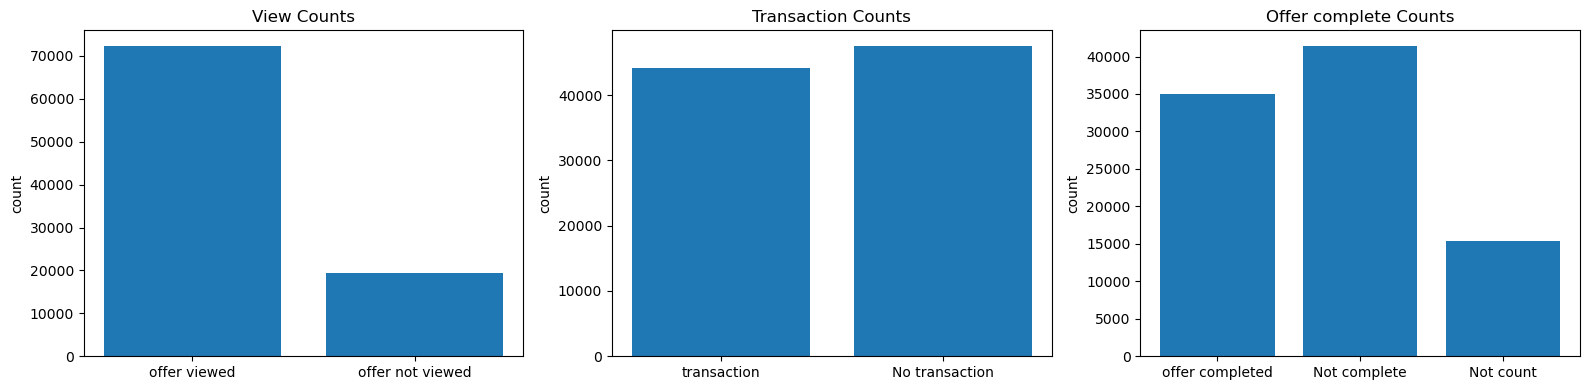

In [200]:
# Create subplots
plt.figure(figsize=(16, 4))

# Plot on the first subplot
plt.subplot(1, 3, 1)
# Return the Series having unique values
x = df_all_plot['view'].unique()
# Return the Series having frequency count of each unique value
y = df_all_plot['view'].value_counts(sort=False)
plt.bar(x, y)
# Labeling the axes
plot_label('View Counts','','count')



# Plot on the second subplot
plt.subplot(1, 3, 2)
# Return the Series having unique values
x = df_all_plot['transaction'].unique()
# Return the Series having frequency count of each unique value
y = df_all_plot['transaction'].value_counts(sort=False)
plt.bar(x, y)
# Labeling the axes
plot_label('Transaction Counts','','count')


plt.subplot(1, 3, 3)
# Return the Series having unique values
x = df_all_plot['complete'].unique()
# Return the Series having frequency count of each unique value
y = df_all_plot['complete'].value_counts(sort=False)
plt.bar(x, y)
# Labeling the axes
plot_label('Offer complete Counts','','count')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Observation**: From the above plot, We can see offer view rate is high, but the transaction followed by the offer is less than 50%

### Question1: Which channel works best for sending offers?

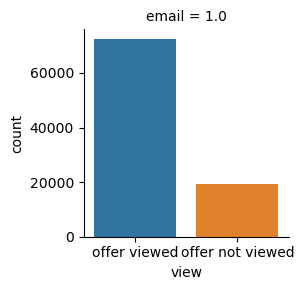

In [222]:
type_order = df_all_plot['view'].unique()
g = sns.FacetGrid(data=df_all_plot, col='email');
g.map_dataframe(sns.countplot,'view',palette=sns.color_palette(),order=type_order).add_legend();

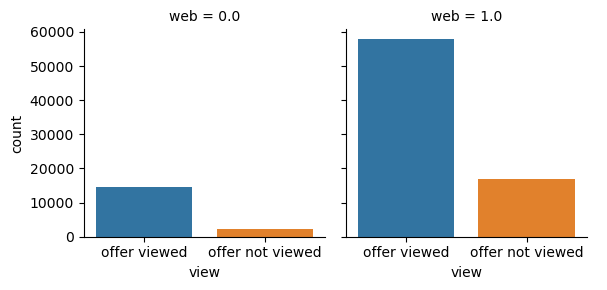

In [223]:
type_order = df_all_plot['view'].unique()
g = sns.FacetGrid(data=df_all_plot, col='web');
g.map_dataframe(sns.countplot,'view',palette=sns.color_palette(),order=type_order).add_legend();

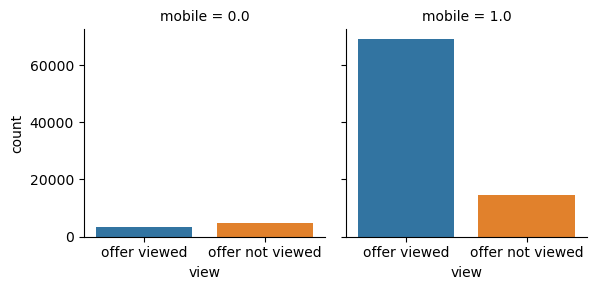

In [224]:
type_order = df_all_plot['view'].unique()
g = sns.FacetGrid(data=df_all_plot, col='mobile');
g.map_dataframe(sns.countplot,'view',palette=sns.color_palette(),order=type_order).add_legend();

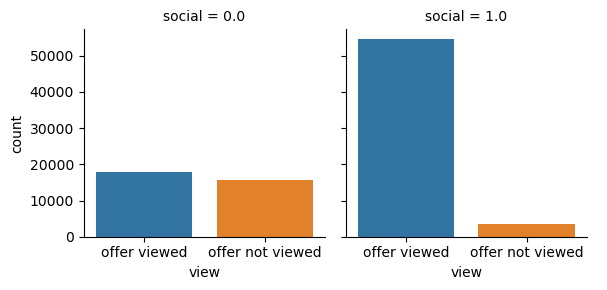

In [225]:
type_order = df_all_plot['view'].unique()
g = sns.FacetGrid(data=df_all_plot, col='social');
g.map_dataframe(sns.countplot,'view',palette=sns.color_palette(),order=type_order).add_legend();

#### Answer:
From the above plot, the 'social' channel has the hightest view rate. So I will conclude the social channel is the best to send out offers if we want to the offer to be viewed.

### Question2: Which type offer is the most effective (i.e customer make most transcations after view the offer)

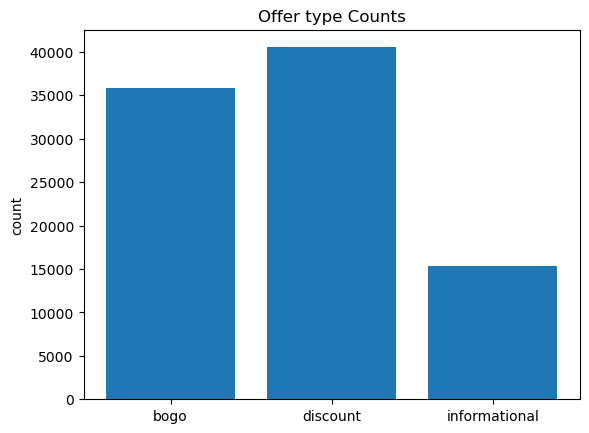

In [226]:
# Return the Series having unique values
x = df_all_plot['offer_type'].unique()
# Return the Series having frequency count of each unique value
y = df_all_plot['offer_type'].value_counts(sort=False)
plt.bar(x, y)
# Labeling the axes
plot_label('Offer type Counts','','count')

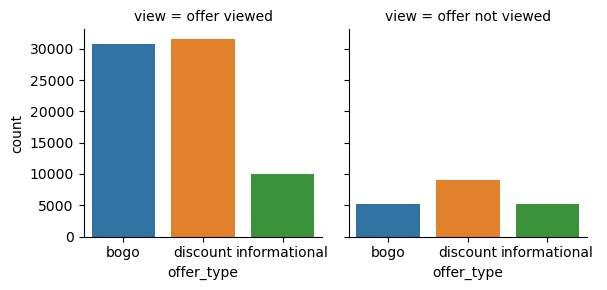

In [227]:
type_order = df_all_plot['offer_type'].unique()
g = sns.FacetGrid(data=df_all_plot, col='view');
g.map_dataframe(sns.countplot,'offer_type',palette=sns.color_palette(),order=type_order).add_legend();

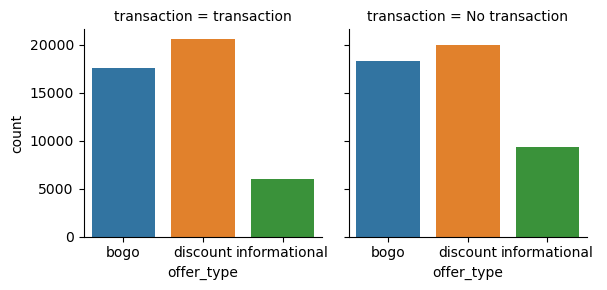

In [228]:
g = sns.FacetGrid(data=df_all_plot, col='transaction');
g.map_dataframe(sns.countplot,'offer_type',palette=sns.color_palette(),order=type_order).add_legend();

In [241]:
# create a dataframe with offer view count by offer_type
df1 = df_all_plot.groupby(['view','offer_type'])['person'].count()
df1['offer viewed']

offer_type
bogo             30750
discount         31535
informational    10068
Name: person, dtype: int64

In [244]:
# create a dataframe with transaction count by offer_type
df2 = df_all_plot.groupby(['transaction','offer_type'])['person'].count()
df2['transaction']

offer_type
bogo             17589
discount         20564
informational     6047
Name: person, dtype: int64

In [245]:
# calculate the transaction rate
df2['transaction']/df1['offer viewed']

offer_type
bogo             0.572000
discount         0.652101
informational    0.600616
Name: person, dtype: float64

#### Answer:
From the plot and calculation above, the discount offers has highest transaction rate after it has been viewed by the customer.

## Model data
In this section, I will use ML models to classify whether a customer is our targeted customer or not. 
A targeted customer is the one who is highly sensative to the offer. Their offer_response rate is above average.
I will use `df_profile_with_class` data frame for this part of analysis

### Question3: How well are different machine leaning methods in classifing targeted customers?

### 1.preprocessing data for models

In [246]:
df_profile_with_class.head()

,gender,age,id,income,member_year,receive_ct,success_ct,offer_response_rate,high-senstive,low-senstive
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,2,0,0.000000,0,1
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,4,3,0.750000,1,0
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,2,0.500000,1,0
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,6,5,0.833333,1,0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,3,0,0.000000,0,1


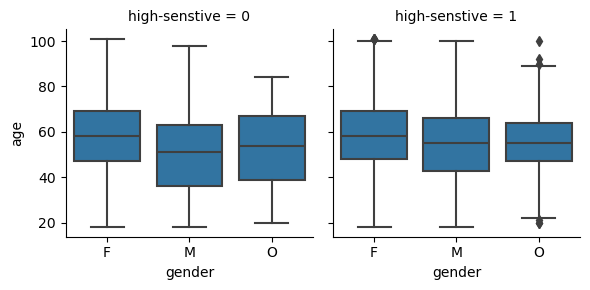

In [251]:
g = sns.FacetGrid(data=df_profile_with_class, col='high-senstive');
g.map_dataframe(sns.boxplot,'gender','age');

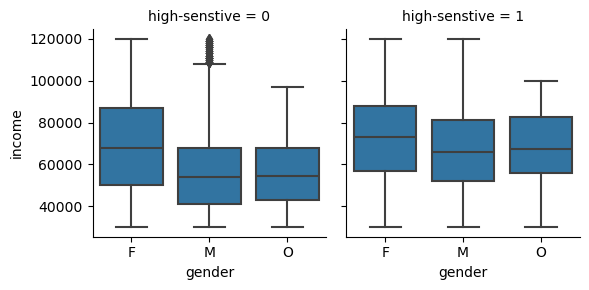

In [252]:
g = sns.FacetGrid(data=df_profile_with_class, col='high-senstive');
g.map_dataframe(sns.boxplot,'gender','income');

**Observation**:
From above plots, high-sensative customers seems to be older and have higher income than low senstive group

### 2. classification using logic regression

In [316]:
def display_results(model, Y_test, Y_pred):
    '''
    Display results for modesl

    Input:
    model- the trained model to be evaluated
    Y_test - the test data for the model
    Y-pred - the predict results for the model

    Output: None
    
    '''
    try:
        coefficients = model.coef_
        intercept = model.intercept_
        print("Coefficients:", coefficients)
        print("Intercept:", intercept)
    except: 
        print('this model has no coefficient \n')
    
    labels = np.unique(Y_pred)
    confusion_mat= pd.DataFrame(confusion_matrix(y_test,y_pred), columns = ["0", "1"], index = ["0", "1"])
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred)

    
    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("Classification report:\n", report)



In [325]:
#create a copy of df_profile_with_class for modeling
df_profile_ml = df_profile_with_class.copy()

# create dummy varibles for gender column
df_profile_ml['female'] = (df_profile_ml['gender'] == 'F').astype('int')
df_profile_ml['male'] = (df_profile_ml['gender'] == 'M').astype('int')

# select predictor for the model
x_cols = ['female','male','age','member_year','income']
y_col = ['high-senstive']
X = df_profile_ml[x_cols]
y = df_profile_ml[y_col].values.ravel()

# splite the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=33)

In [326]:
# fit the logic model to the train data 
model1 = LogisticRegression()
res1 = model1.fit(X_train, y_train)

# display model summary and the accuracy report for test data
y_pred = res1.predict(X_test)
display_results(model1,y_test, y_pred);

Coefficients: [[ 3.66245271e-04 -3.99241327e-04  5.05720780e-03 -7.87277006e-04
   1.99670761e-05]]
Intercept: [3.77159206e-07]
Labels: [0 1]
Confusion Matrix:
       0    1
0  1254  640
1   812  999
Accuracy: 0.6080971659919029
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.63      1894
           1       0.61      0.55      0.58      1811

    accuracy                           0.61      3705
   macro avg       0.61      0.61      0.61      3705
weighted avg       0.61      0.61      0.61      3705



**Conclusion for Logic model**: The logic model has a average accuracy about 61%

### 3. classification using LDA

In [327]:
# fit the logic model to the train data 
model2 = LinearDiscriminantAnalysis()
res2 = model2.fit(X_train, y_train)

# display model summary and the accuracy report for test data
y_pred = res2.predict(X_test)
display_results(model2,y_test, y_pred);

Coefficients: [[-4.07406259e-01 -8.85852961e-01  3.98727385e-03 -3.08132295e-01
   1.83605209e-05]]
Intercept: [620.63075385]
Labels: [0 1]
Confusion Matrix:
       0     1
0  1270   624
1   717  1094
Accuracy: 0.6380566801619433
Classification report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65      1894
           1       0.64      0.60      0.62      1811

    accuracy                           0.64      3705
   macro avg       0.64      0.64      0.64      3705
weighted avg       0.64      0.64      0.64      3705



**Conclusion for LDA model**: The LDA model has a average accuracy about 64%

### 4. classification using QDA

In [328]:
# fit the logic model to the train data 
model3 = QuadraticDiscriminantAnalysis()
res3 = model3.fit(X_train, y_train)

# display model summary and the accuracy report for test data
y_pred = res3.predict(X_test)
display_results(model3,y_test, y_pred);

this model has no coefficient 

Labels: [0 1]
Confusion Matrix:
       0    1
0  1485  409
1   893  918
Accuracy: 0.648582995951417
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.78      0.70      1894
           1       0.69      0.51      0.59      1811

    accuracy                           0.65      3705
   macro avg       0.66      0.65      0.64      3705
weighted avg       0.66      0.65      0.64      3705



**Conclusion for QDA model**: The LDA model has a average accuracy about 65%

### 5. classification using KNN

In [329]:
# fit the logic model to the train data 
model4 = KNeighborsClassifier(n_neighbors=1)
res4 = model4.fit(X_train, y_train)

# display model summary and the accuracy report for test data
y_pred = res4.predict(X_test)
display_results(model4,y_test, y_pred);

this model has no coefficient 

Labels: [0 1]
Confusion Matrix:
       0     1
0  1033   861
1   799  1012
Accuracy: 0.5519568151147098
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.55      0.55      1894
           1       0.54      0.56      0.55      1811

    accuracy                           0.55      3705
   macro avg       0.55      0.55      0.55      3705
weighted avg       0.55      0.55      0.55      3705



**Observation**: The KNN only got the accuracy=55% with k = 1. I will test with different k values

In [330]:
# loop through KNN with diff K values

# k = 1 to (n-1)
n = 10 
for k in range(1,n):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy with k={}:{:.2f}".format(k, accuracy_score(y_test, y_pred)))

Accuracy with k=1:0.55
Accuracy with k=2:0.56
Accuracy with k=3:0.57
Accuracy with k=4:0.58
Accuracy with k=5:0.59
Accuracy with k=6:0.59
Accuracy with k=7:0.60
Accuracy with k=8:0.59
Accuracy with k=9:0.59


**Conclusion**: The highest accuracy a KNN can got is 60% with k = 7. It is not better than other models.

## Results discussion
When compare different models, we can see QDA has the highest prediction accuracy. But since our data is limited, the accuracy of the model is not very high.

## Conclusion and futher improvement
To further improve the model, I can do the following:
1. Collect more data
2. Use other classification method, such as random forest
3. Dig more features of the customer, such as races, location, work type and so on.